In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

df = pd.read_csv('Data Final_Employee Attrition.csv')
df = df.rename(columns={'BusinessTravel':'Business Travel'})
import re
df = df.rename(columns=lambda col: re.sub(r"\s+", "_", col.lower()))
first_column = 'employee_number'
df = pd.concat([df[first_column], df.drop(columns=[first_column])], axis=1)

#Define only the numeric columns
cont = df.select_dtypes(include=[np.number])
#Drop ordinal columns
cont = cont.drop(columns= {'employee_number', 'standard_hours', 'education', 'environment_satisfaction',
                           'job_involvement', 'job_level', 'job_satisfaction', 'performance_rating', 'relationship_satisfaction',
                           'stock_option_level', 'work_life_balance'}, axis=1)

cont['attrition'] = df['attrition']
cont.insert(0, 'attrition', cont.pop('attrition'))
cont

,attrition,age,daily_rate,distance_from_home,hourly_rate,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,total_working_years,training_times_last_year,years_at_company,years_in_current_role,years_since_last_promotion,years_with_current_manager
0,Yes,41,1102,1,94,5993,19479,8,11,8,0,6,4,0,5
1,No,49,279,8,61,5130,24907,1,23,10,3,10,7,1,7
2,Yes,37,1373,2,92,2090,2396,6,15,7,3,0,0,0,0
3,No,33,1392,3,56,2909,23159,1,11,8,3,8,7,3,0
4,No,27,591,2,40,3468,16632,9,12,6,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,No,36,884,23,41,2571,12290,4,17,17,3,5,2,0,3
1466,No,39,613,6,42,9991,21457,4,15,9,5,7,7,1,7
1467,No,27,155,4,87,6142,5174,1,20,6,0,6,2,0,3
1468,No,49,1023,2,63,5390,13243,2,14,17,3,9,6,0,8


In [3]:
#Mann-Whitney U test for Power & Effect Size
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

cont_vars = cont.select_dtypes(include='number').columns.tolist()
cont_vars = [var for var in cont_vars if var != 'attrition']

result_dict = {}

for cont_var in cont_vars:
    group1 = cont[cont['attrition'] == 'No'][cont_var]
    group2 = cont[cont['attrition'] == 'Yes'][cont_var]

    statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    n1, n2 = len(group1), len(group2)
    u1 = n1 * n2 + (n1 * (n1 + 1)) / 2 - group1.rank().sum()
    effect_size = abs(statistic / (n1 * n2))

    power = sm.stats.tt_ind_solve_power(effect_size=effect_size, nobs1=len(group1), alpha=0.05, alternative='two-sided')

    result_dict[cont_var] = {'Power': power, 'Effect Size': effect_size}

result_df = pd.DataFrame(result_dict).T
result_df

,Power,Effect Size
age,1.0,0.634321
daily_rate,1.0,0.544721
distance_from_home,1.0,0.438009
hourly_rate,1.0,0.505253
monthly_income,1.0,0.655670
monthly_rate,1.0,0.488023
num_companies_worked,1.0,0.476665
percent_salary_hike,1.0,0.518424
total_working_years,1.0,0.655853
training_times_last_year,1.0,0.538755


In [4]:
#Hypothesis Testing using Mann-Whitney U test
result_dict = {}

for cont_var in cont_vars:
    group1 = cont[cont['attrition'] == 'No'][cont_var]
    group2 = cont[cont['attrition'] == 'Yes'][cont_var]

    statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    result_dict[cont_var] = {'MannWhitneyU_statistic': statistic, 'p_value': f"{p_value:.4f}"}

result_df = pd.DataFrame(result_dict).T
result_df

,MannWhitneyU_statistic,p_value
age,185362.0,0.0000
daily_rate,159179.0,0.0290
distance_from_home,127995.5,0.0024
hourly_rate,147645.5,0.7976
monthly_income,191600.5,0.0000
monthly_rate,142610.5,0.5587
num_companies_worked,139291.5,0.2424
percent_salary_hike,151494.5,0.3655
total_working_years,191654.0,0.0000
training_times_last_year,157435.5,0.0473


In [5]:
# Median and count differences grouped by 'attrition'
cont_sig = cont.drop(columns=['hourly_rate', 'monthly_rate', 'num_companies_worked', 'percent_salary_hike'])

result = cont_sig.groupby('attrition').agg(['median', 'count'])

result = result.round(3)

count_columns = result.columns.get_level_values(1) == 'count'
result[result.columns[count_columns]] = result[result.columns[count_columns]].astype(int).astype(str).replace('\.0', '', regex=True)

result.T

attrition                              No     Yes
age                        median    36.0    32.0
                           count     1233     237
daily_rate                 median   817.0   699.0
                           count     1233     237
distance_from_home         median     7.0     9.0
                           count     1233     237
monthly_income             median  5204.0  3202.0
                           count     1233     237
total_working_years        median    10.0     7.0
                           count     1233     237
training_times_last_year   median     3.0     2.0
                           count     1233     237
years_at_company           median     6.0     3.0
                           count     1233     237
years_in_current_role      median     3.0     2.0
                           count     1233     237
years_since_last_promotion median     1.0     1.0
                           count     1233     237
years_with_current_manager median     3.0     2.0
                           count     1233     237

In [6]:
#Normality testing of whole variables
from scipy.stats import kstest

def test_normality(column):
    statistic, p_value = kstest(column, 'norm')
    alpha = 0.05
    is_normal = p_value > alpha
    return statistic, p_value, is_normal

results_list = []

for column in cont.columns:
    if column != 'attrition':
        statistic, p_value, is_normal = test_normality(cont[column])
        results_list.append({
            'Column': column,
            'KS Statistic': statistic,
            'P-value': p_value,
            'Is Normal': is_normal
        })

results_df = pd.concat([pd.DataFrame([result]) for result in results_list], ignore_index=True)
results_df

,Column,KS Statistic,P-value,Is Normal
0,age,1.000000,0.0,False
1,daily_rate,1.000000,0.0,False
2,distance_from_home,0.841345,0.0,False
3,hourly_rate,1.000000,0.0,False
4,monthly_income,1.000000,0.0,False
5,monthly_rate,1.000000,0.0,False
6,num_companies_worked,0.707331,0.0,False
7,percent_salary_hike,1.000000,0.0,False
8,total_working_years,0.914977,0.0,False
9,training_times_last_year,0.892216,0.0,False


In [7]:
from scipy.stats import pointbiserialr

cont['attrition'] = cont['attrition'].map({'No': 0, 'Yes': 1})

results = pd.DataFrame(columns=['Relationship', 'Point-biserial Corr', 'P-value', 'Significance'])

for column in cont.columns:
    if column != 'attrition':
        variable_name = f'{column} & attrition'
        variable = cont[column]
        correlation, p_value = pointbiserialr(cont['attrition'], variable)
        
        significance = 'Significant' if p_value < 0.05 else 'Not Significant'
        
        results = pd.concat([results, pd.DataFrame({
            'Relationship': [variable_name],
            'Point-biserial Corr': [correlation],
            'P-value': ['{:.4f}'.format(p_value)],
            'Significance': [significance]
        })], ignore_index=True)

results

,Relationship,Point-biserial Corr,P-value,Significance
0,age & attrition,-0.159205,0.0000,Significant
1,daily_rate & attrition,-0.056652,0.0299,Significant
2,distance_from_home & attrition,0.077924,0.0028,Significant
3,hourly_rate & attrition,-0.006846,0.7931,Not Significant
4,monthly_income & attrition,-0.159840,0.0000,Significant
5,monthly_rate & attrition,0.015170,0.5611,Not Significant
6,num_companies_worked & attrition,0.043494,0.0955,Not Significant
7,percent_salary_hike & attrition,-0.013478,0.6056,Not Significant
8,total_working_years & attrition,-0.171063,0.0000,Significant
9,training_times_last_year & attrition,-0.059478,0.0226,Significant


In [8]:
#Spearman correlation coefficient
from scipy.stats import spearmanr

results_spearman = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Spearman Corr', 'P-value', 'Significance'])

for i, col1 in enumerate(cont.drop(columns=['attrition']).columns):
    for col2 in cont.columns[i+1:]:
        correlation, p_value = spearmanr(cont[col1], cont[col2])
        
        significance = 'Significant' if p_value < 0.05 else 'Not Significant'
        
        results_spearman = pd.concat([results_spearman, pd.DataFrame({
            'Variable 1': [col1],
            'Variable 2': [col2],
            'Spearman Corr': [correlation],
            'P-value': ['{:.4f}'.format(p_value)],
            'Significance': [significance]
        })], ignore_index=True)

results_spearman

,Variable 1,Variable 2,Spearman Corr,P-value,Significance
0,age,age,1.000000,0.0000,Significant
1,age,daily_rate,0.007290,0.7800,Not Significant
2,age,distance_from_home,-0.019291,0.4599,Not Significant
3,age,hourly_rate,0.028858,0.2688,Not Significant
4,age,monthly_income,0.471902,0.0000,Significant
...,...,...,...,...,...
100,years_in_current_role,years_since_last_promotion,0.505657,0.0000,Significant
101,years_in_current_role,years_with_current_manager,0.724754,0.0000,Significant
102,years_since_last_promotion,years_since_last_promotion,1.000000,0.0000,Significant
103,years_since_last_promotion,years_with_current_manager,0.466713,0.0000,Significant


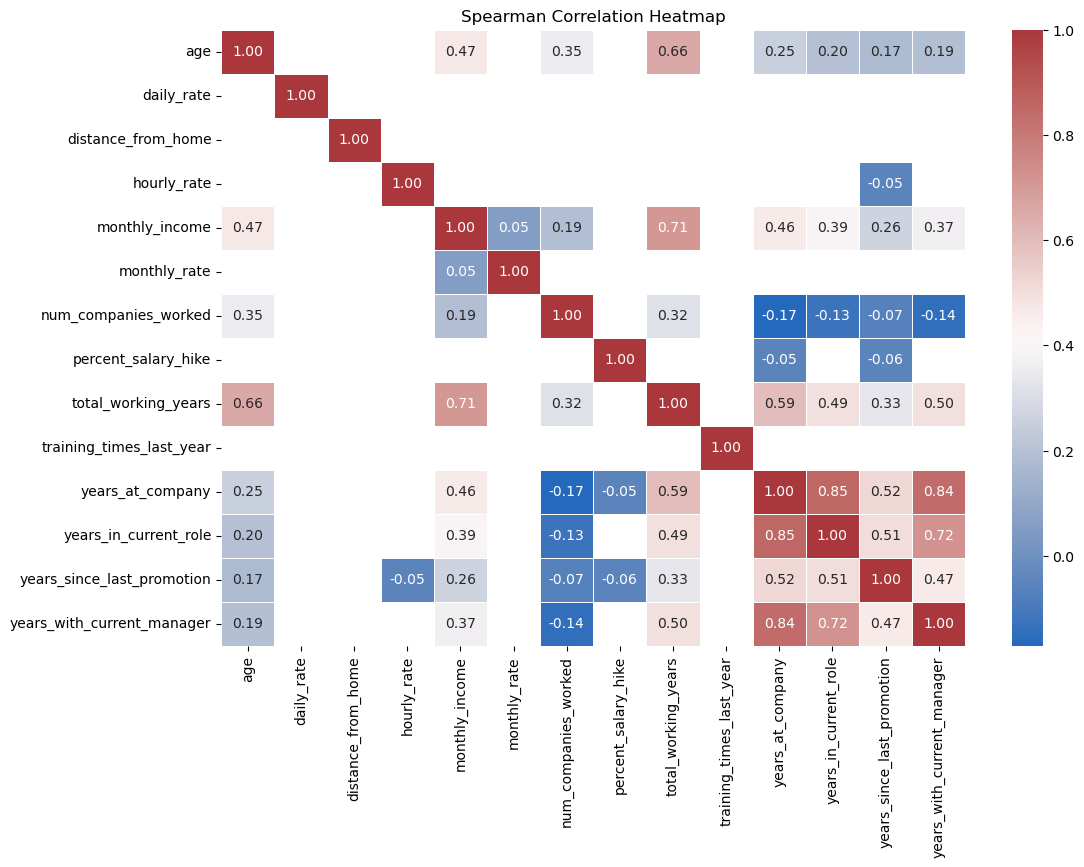

In [9]:
#Spearman correlation heatmap with non-significant Correlations omitted
cat_var = cont['attrition']
cont_var = cont.drop(columns=['attrition'])

spearman_corr_matrix, p_values = spearmanr(cont_var)
mask = p_values > 0.05
spearman_corr_matrix[mask] = None

plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='vlag', fmt=".2f", linewidths=0.5, xticklabels=cont_var.columns, yticklabels=cont_var.columns)

plt.title('Spearman Correlation Heatmap')
plt.show()

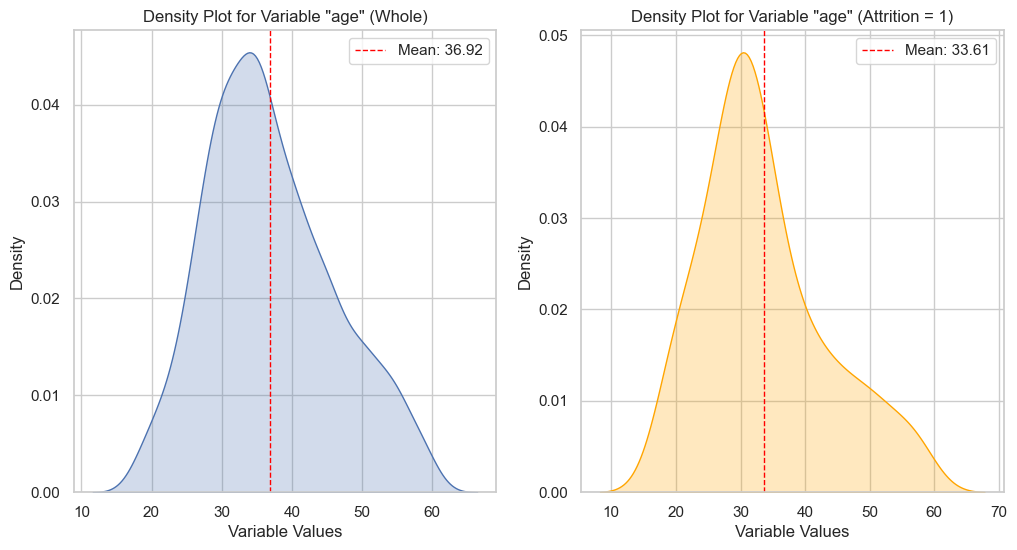

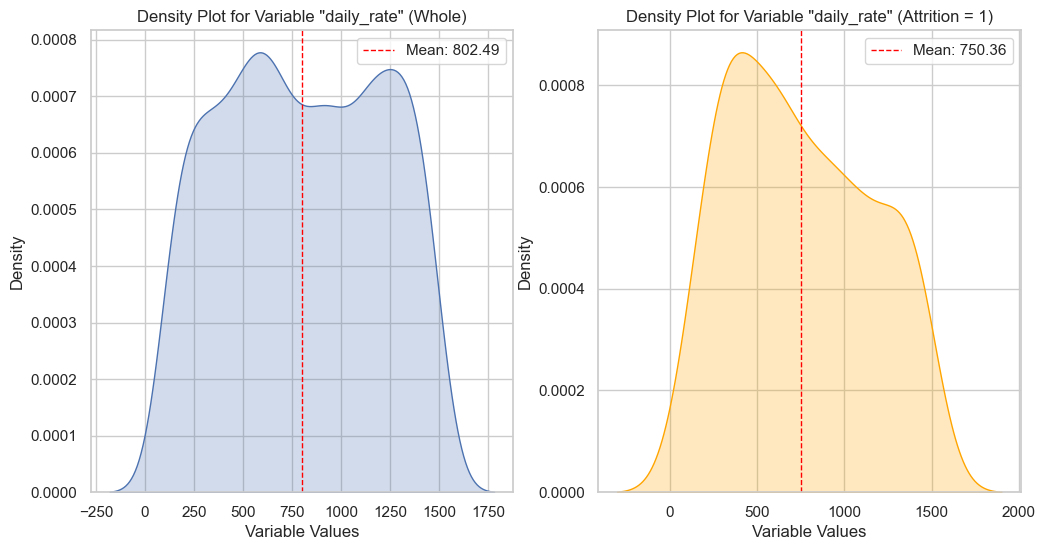

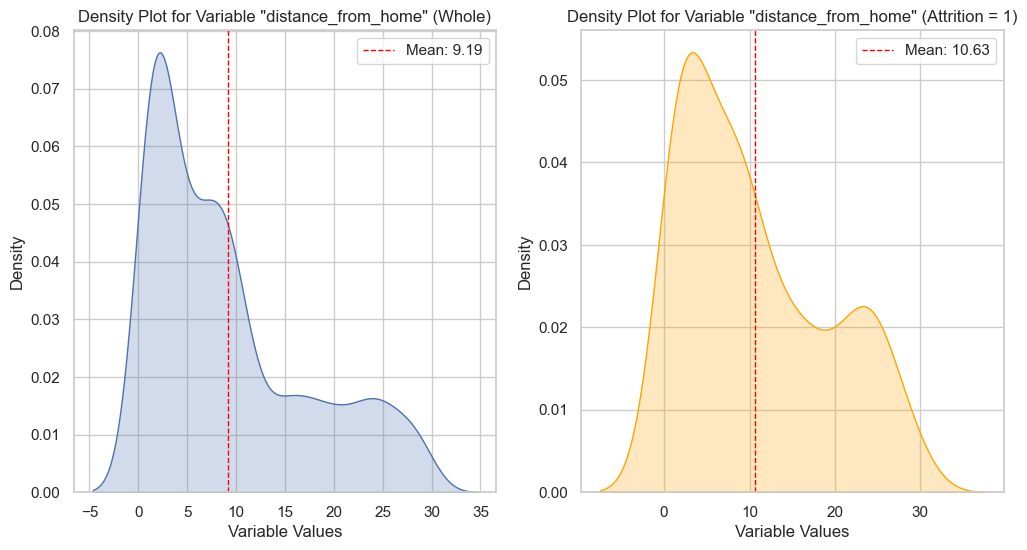

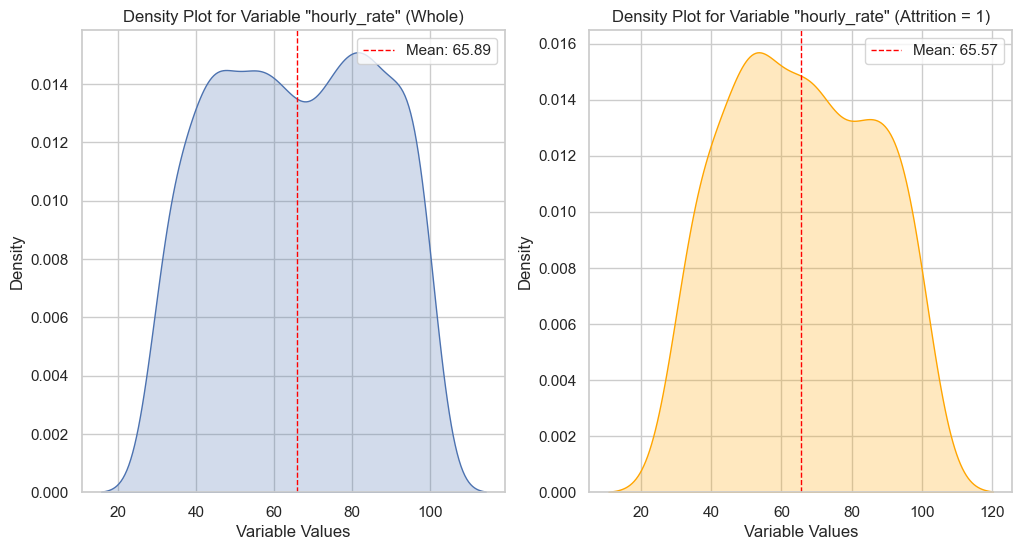

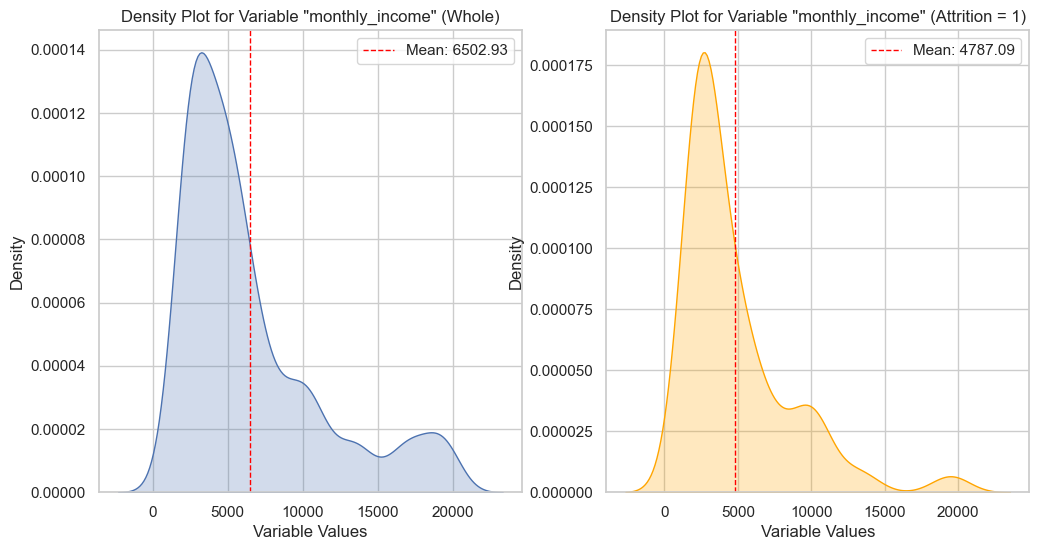

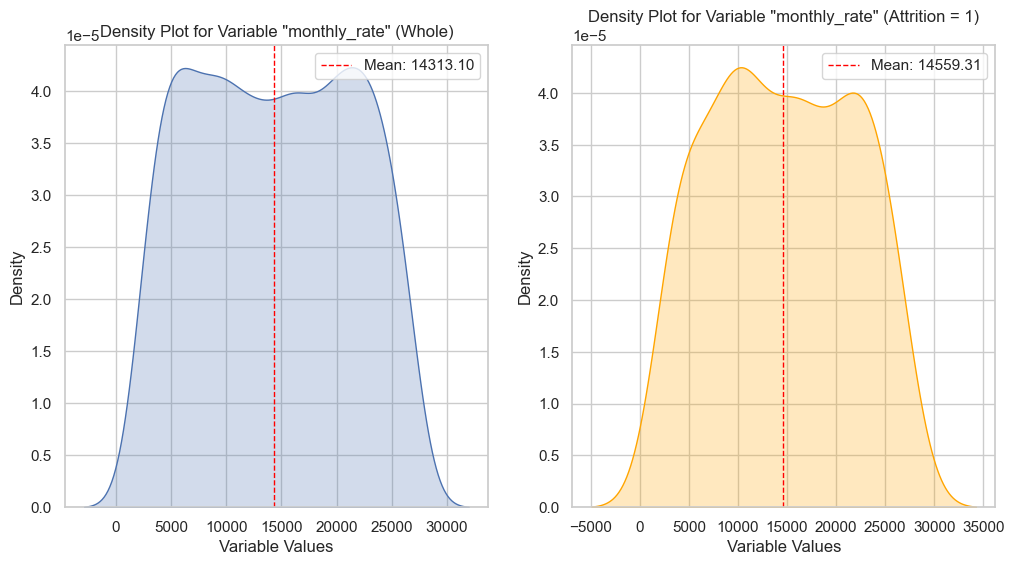

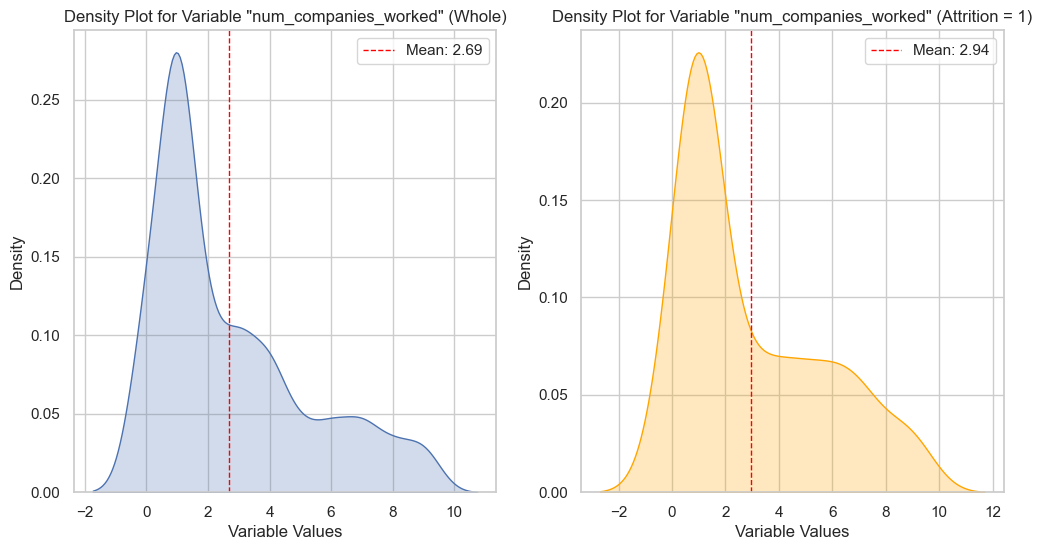

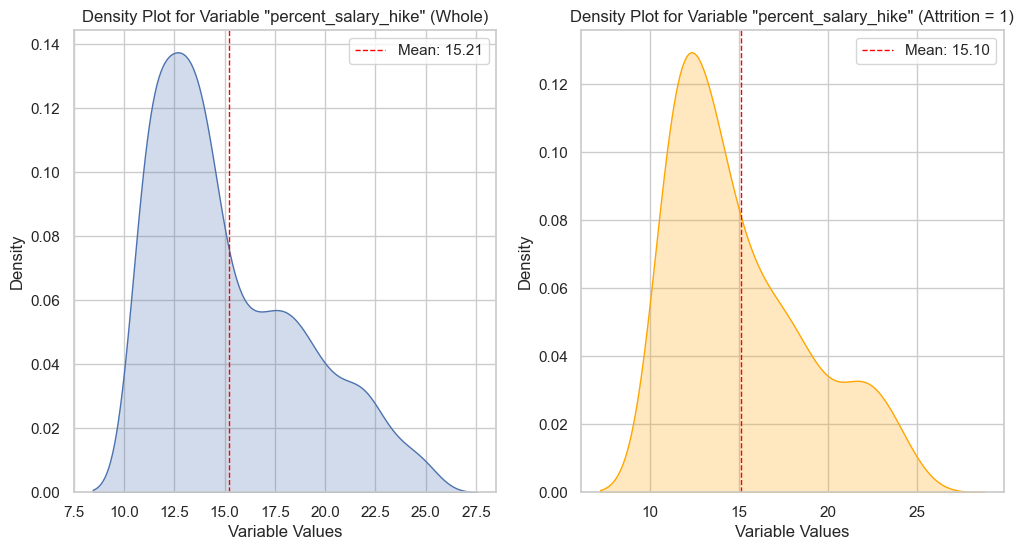

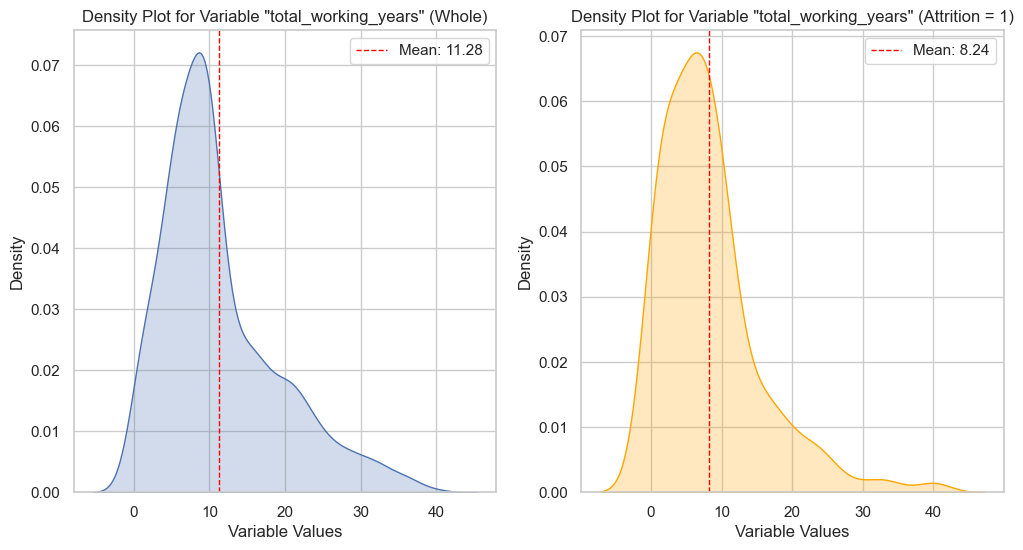

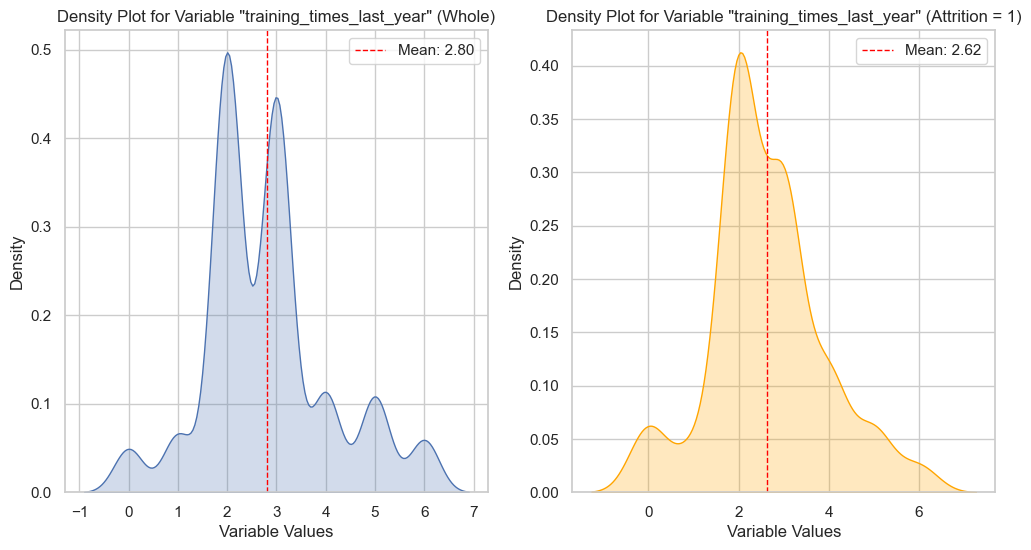

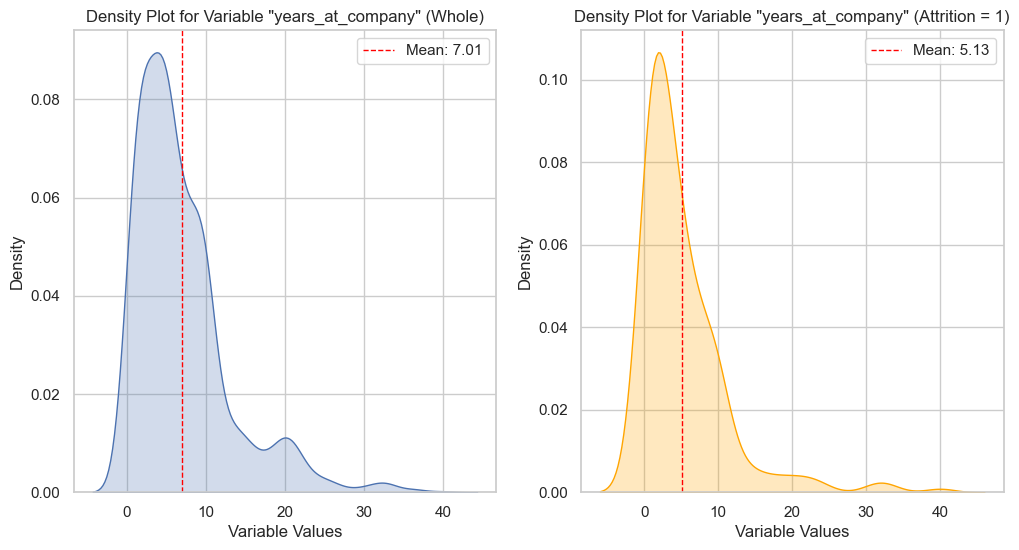

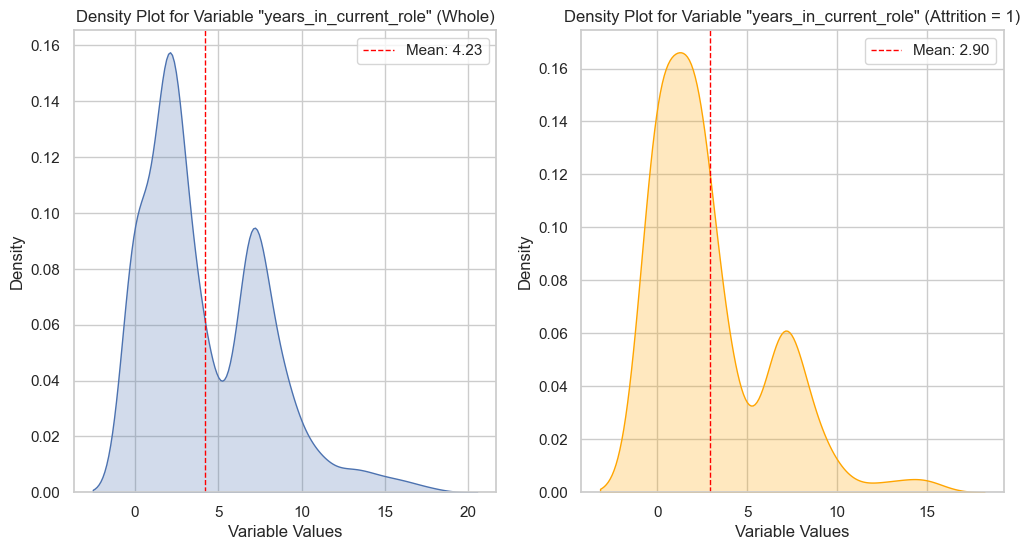

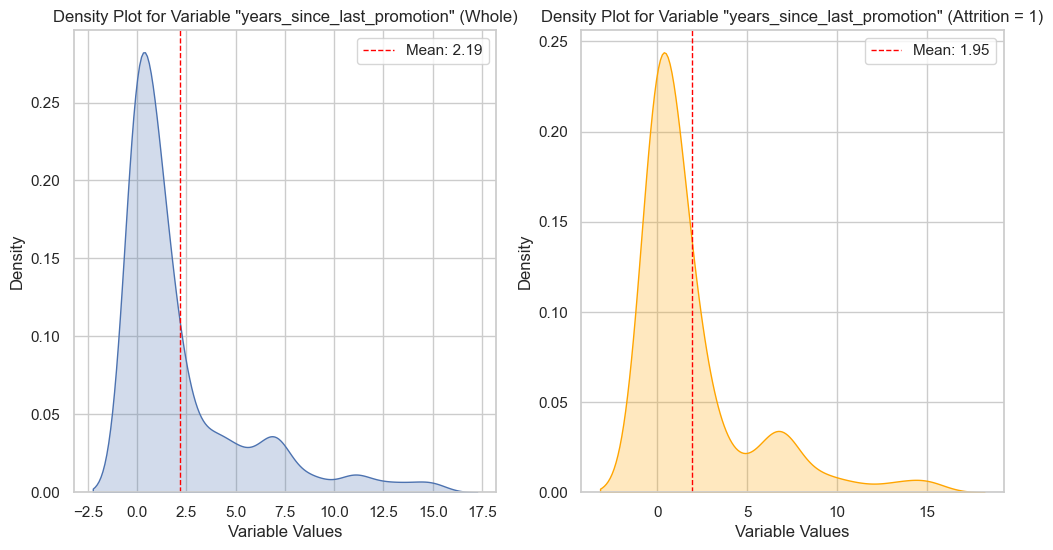

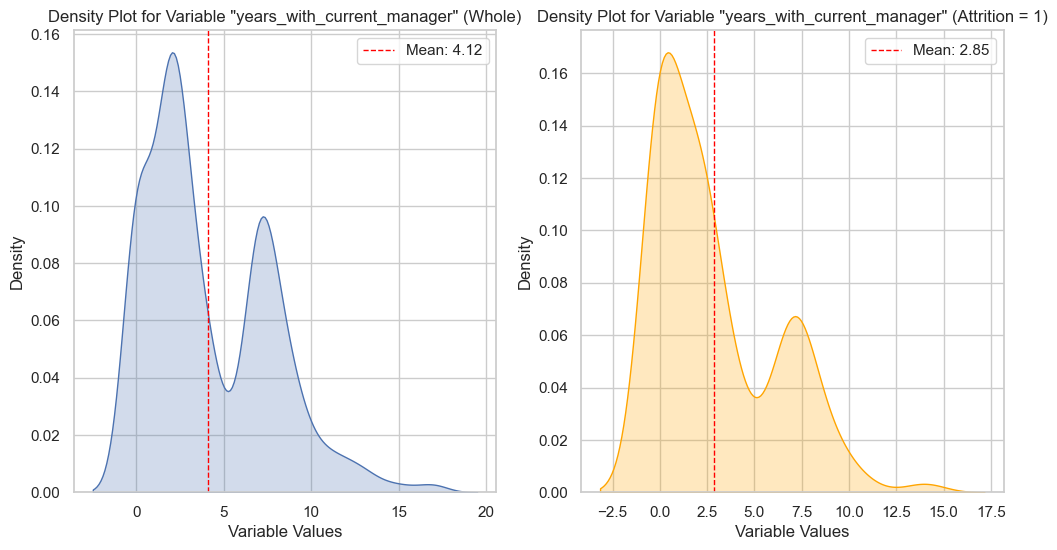

In [10]:
#Density Plots
sns.set(style="whitegrid")

for column in cont.columns:
    if cont[column].dtype != 'object' and column != 'attrition':
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.kdeplot(data=cont[column], fill=True)
        mean_value = cont[column].mean()
        plt.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}', linewidth=1)
        plt.legend()
        plt.xlabel('Variable Values')
        plt.ylabel('Density')
        plt.title(f'Density Plot for Variable "{column}" (Whole)')

        plt.subplot(1, 2, 2)
        sns.kdeplot(data=cont[cont['attrition'] == 1][column], fill=True, color='orange')
        mean_value_att_1 = cont[cont['attrition'] == 1][column].mean()
        plt.axvline(x=mean_value_att_1, color='red', linestyle='--', label=f'Mean: {mean_value_att_1:.2f}', linewidth=1)
        plt.legend()
        plt.xlabel('Variable Values')
        plt.ylabel('Density')
        plt.title(f'Density Plot for Variable "{column}" (Attrition = 1)')

        plt.show()

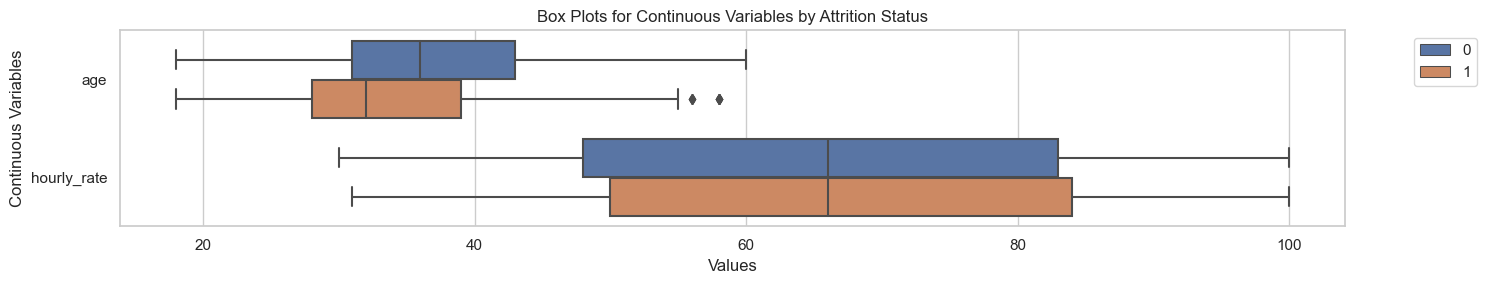

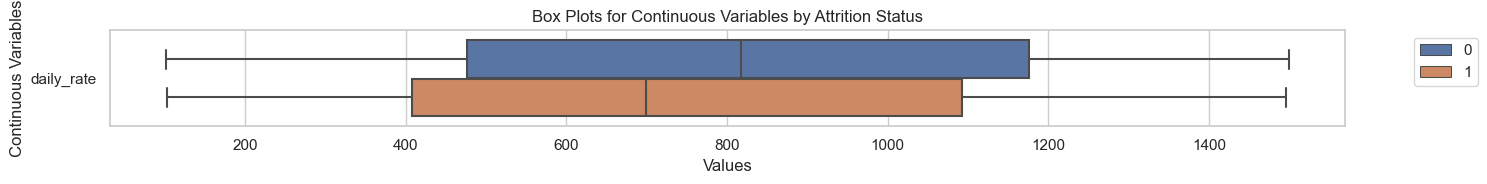

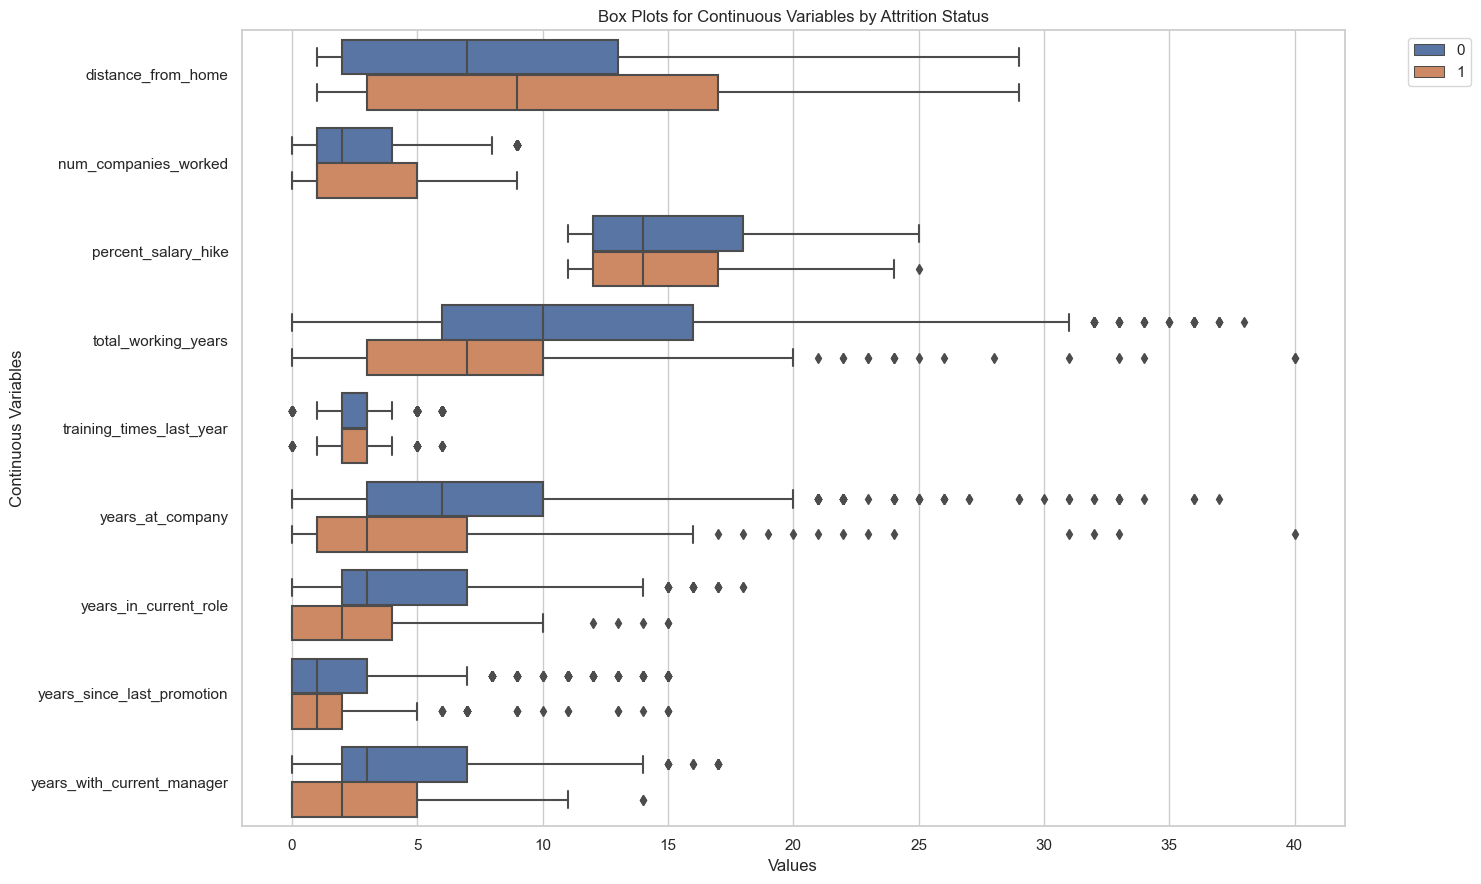

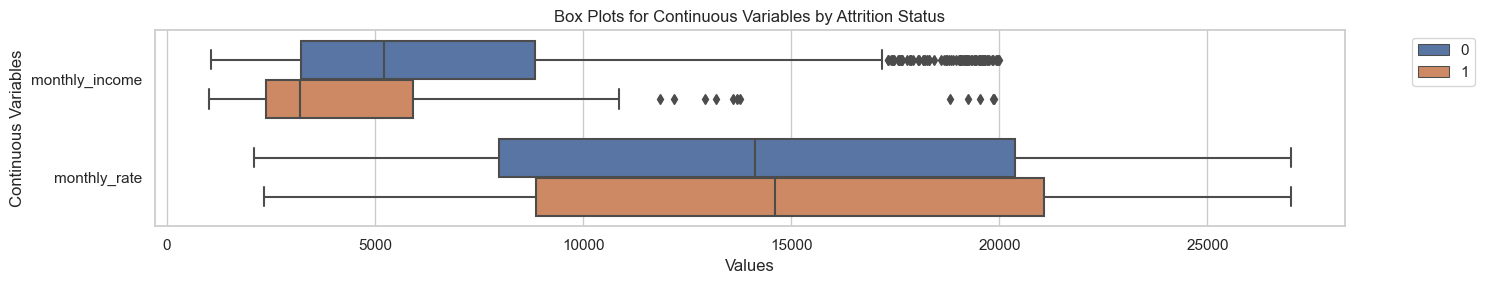

In [11]:
# Box plots
def plot_box_plots(data, vars_to_plot, figsize):
    cont_melted = data.melt(id_vars='attrition', value_vars=vars_to_plot,
                            var_name='variable', value_name='value')

    plt.figure(figsize=figsize)
    ax = sns.boxplot(x='value', y='variable', hue='attrition', data=cont_melted, orient='h')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('Box Plots for Continuous Variables by Attrition Status')
    plt.xlabel('Values')
    plt.ylabel('Continuous Variables')
    plt.tight_layout()
    plt.show()

cont_var1 = ['age', 'hourly_rate']
plot_box_plots(cont, cont_var1, (15, 3))

cont_var2 = ['daily_rate']
plot_box_plots(cont, cont_var2, (15, 2))

cont_var3 = ['distance_from_home', 'num_companies_worked', 'percent_salary_hike', 'total_working_years', 'training_times_last_year',
             'years_at_company', 'years_in_current_role', 'years_since_last_promotion', 'years_with_current_manager']
plot_box_plots(cont, cont_var3, (15, 9))

cont_var4 = ['monthly_income', 'monthly_rate']
plot_box_plots(cont, cont_var4, (15, 3))